In [1]:
import numpy as np
from scipy.stats import cumfreq
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split(':')[-1]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [4]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr16', 70399987, '+', 'RP11-529K1.3')


In [5]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X += [onehot(seq).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 4) (37110, 70, 4)


In [6]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [7]:
y_novel = model.predict(X_novel).reshape(-1, L)
p_known = model.predict(X_known).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [8]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

# ISM

This is last bit of code using old variant annotations. It would be nice if we can swap these out, but not urgent.

In [41]:
from sklearn.utils import shuffle
import pandas

def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'), random_state=0)

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')
benign = read_variants('../../hg19.benign.exons.tsv')

In [42]:
def get_features(p):
    X_ref, X_alt, indexes = [], [], []
    for pos, shift, chrom, strand, ref, alt in zip(p['POS'],
                                                   p["3'Dist"],
                                                   p['CHROM'],
                                                   p['strand'],
                                                   p['REF'],
                                                   p['ALT']):
        chrom = 'chr'+str(chrom)
        three = pos + (-shift if strand == '+' else shift-1)
        if strand == '+':
            begin, stop = three - L, three + len(ref) - 1
        else:
            begin, stop = three - len(ref)+1, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X_ref += [onehot(seq[-70:]).reshape(1, 70, 4)]
        indexes += [L+shift-1]

        altseq = (seq[:indexes[-1]]
                  + (alt if strand == '+' else genome.revcomp(alt))
                  + seq[indexes[-1]+len(ref):])
        X_alt += [onehot(altseq[-70:]).reshape(1, 70, 4)]

    return np.vstack(X_ref), np.vstack(X_alt), np.array(indexes)

def get_stats(ref, alt, indexs):
    old = []
    new = []
    for r, a in zip(ref, alt):
        bp = np.argmax(r)
        old += [a[bp] - r[bp]]
        bp = np.argmax(a)
        new += [a[bp] - r[bp]]
    old = np.array(old)
    new = np.array(new)
    max_delta = np.max(alt, axis = 1) - np.max(ref, axis = 1)
    shift = indexs - np.argmax(ref, axis =1)
    return shift, old, new, max_delta

In [43]:
p = pathogenic[(pathogenic["3'Dist"] > -45) & (pathogenic["3'Dist"] <= -18)]

path_X_ref, path_X_alt, path_indexes = get_features(p)

path_shift, path_delta, path_gain, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                              model.predict(path_X_alt).reshape(-1, L),
                                                              path_indexes)

b = benign[(benign["3'Dist"] > -45) & (benign["3'Dist"] <= -18)][:10000]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_gain, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                                      model.predict(benign_X_alt).reshape(-1, L),
                                                                      benign_indexes)

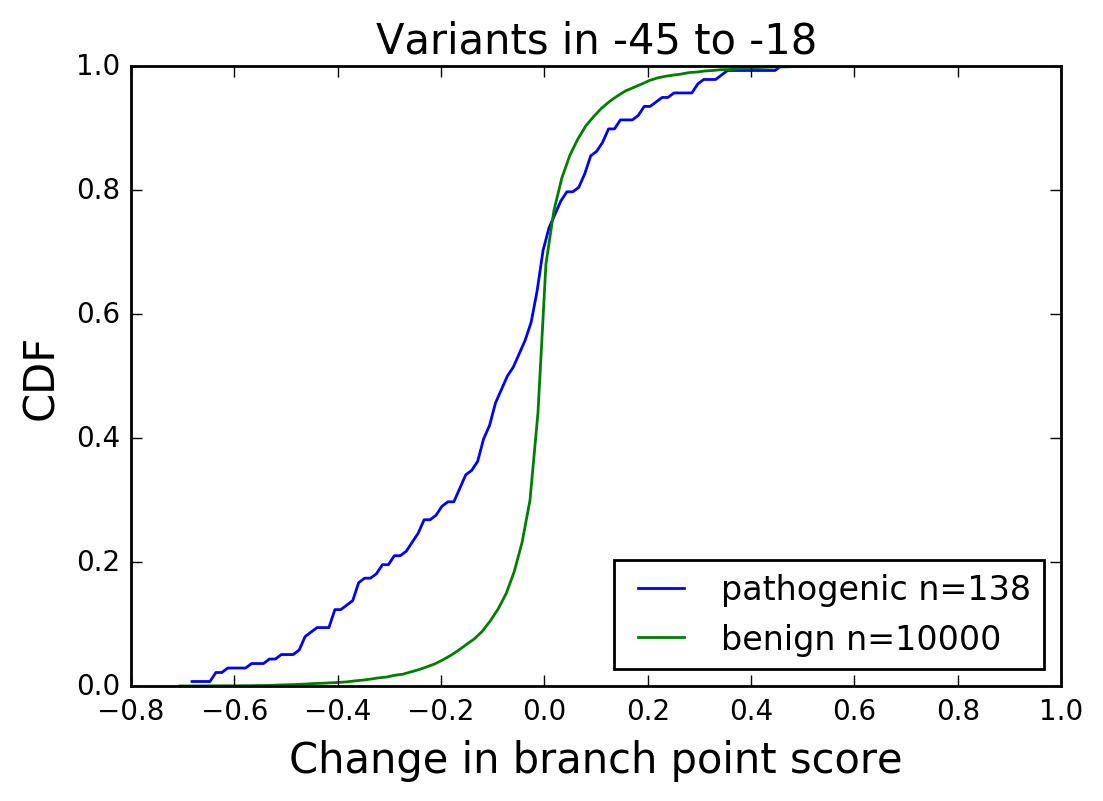

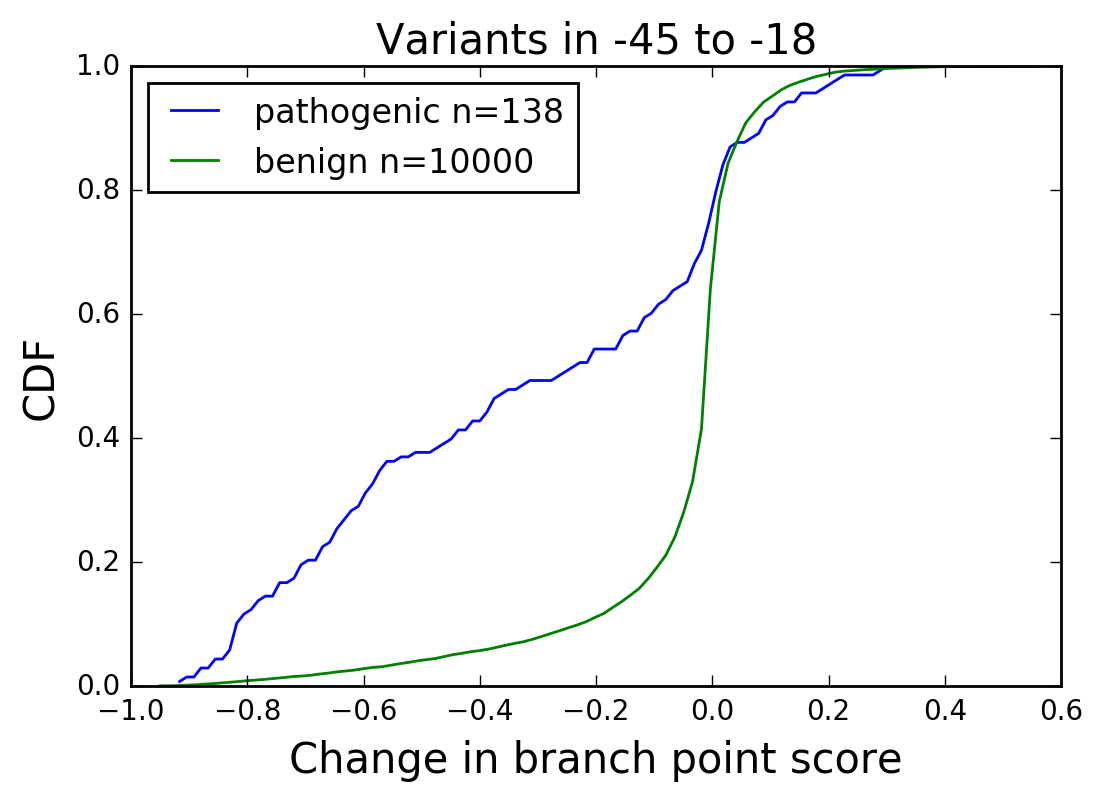

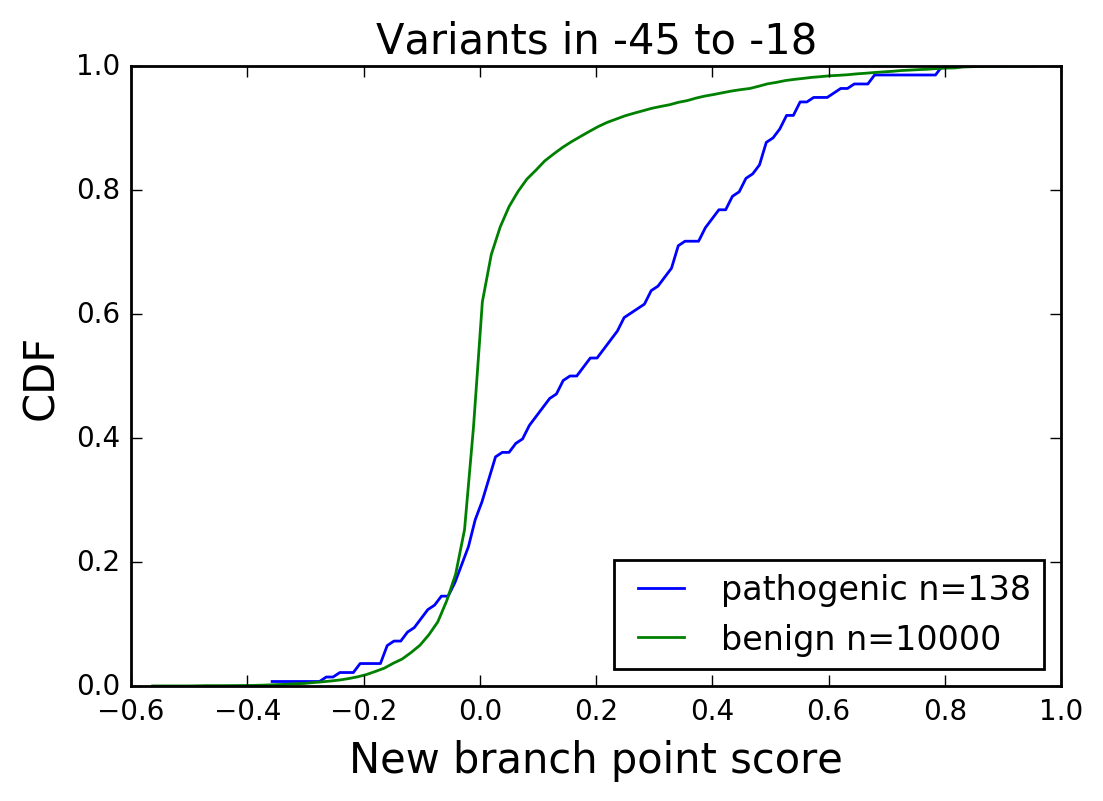

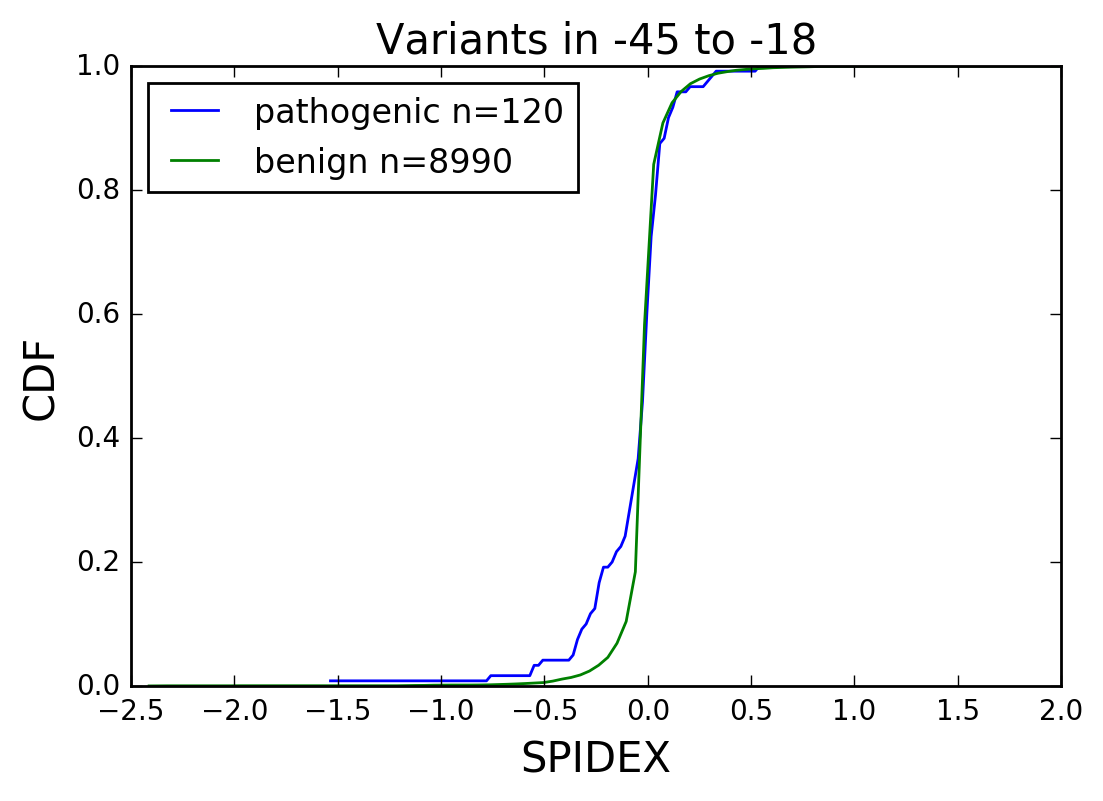

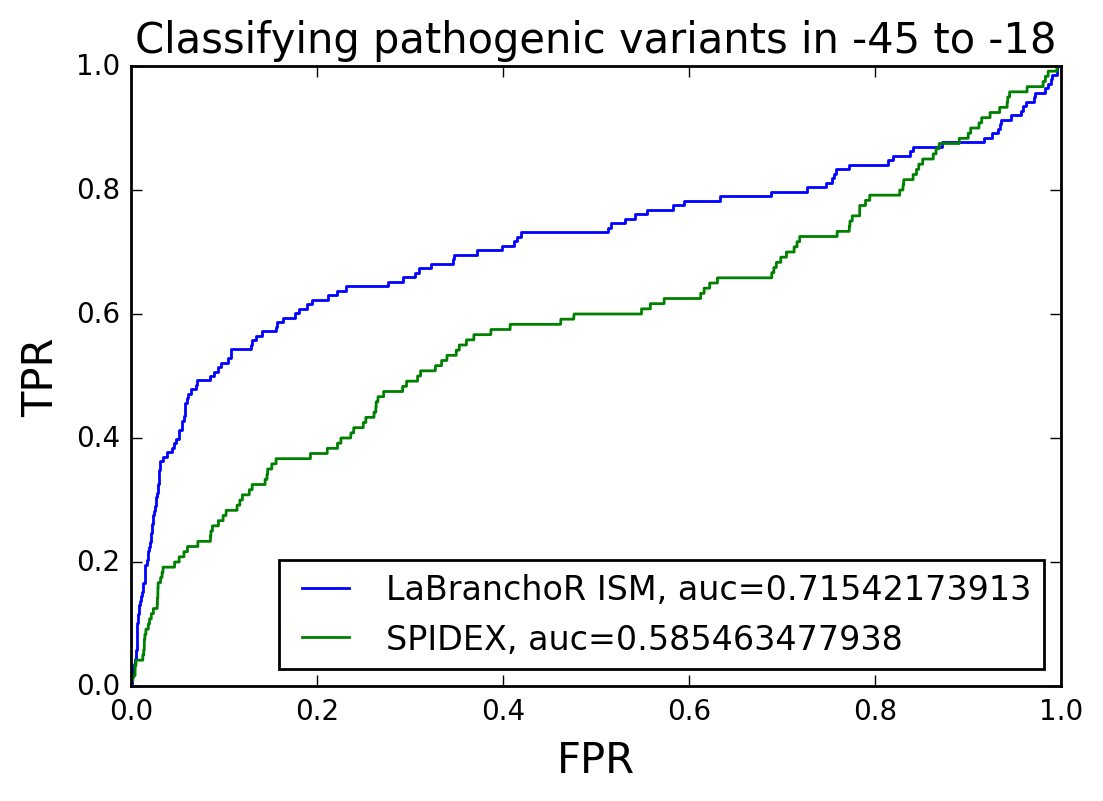

In [44]:
def cdf(a, label, bins = 100):
    c = cumfreq(a, bins)
    lower = c.lowerlimit
    upper = lower + bins * c.binsize
    plt.plot(np.linspace(lower, upper, bins),
             c.cumcount / a.shape[0],
             label = label)
    
def compare_cdfs(path, benign, title, xlabel):
    cdf(path, "pathogenic n={}".format(path.shape[0]))
    cdf(benign, "benign n={}".format(benign.shape[0]))
    plt.legend()
    plt.ylabel('CDF')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()

compare_cdfs(path_max_delta, benign_max_delta,
             'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_delta, benign_delta,
             'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_gain, benign_gain,
             'Variants in -45 to -18', 'New branch point score')
compare_cdfs(p[p['SPIDEX'] != float('inf')]['SPIDEX']/10,
             b[b['SPIDEX'] != float('inf')]['SPIDEX']/10,
            'Variants in -45 to -18', 'SPIDEX')

from sklearn import metrics
def roc(p, b):
    y = np.hstack([np.ones(p.shape), np.zeros(b.shape)])
    s = np.hstack([p, b])
    fpr, tpr, thresh = metrics.roc_curve(y, -s)
    return fpr, tpr, metrics.roc_auc_score(y, -s)


fpr, tpr, auc = roc(path_delta, benign_delta)
plt.plot(fpr, tpr, label = "LaBranchoR ISM, auc={}".format(auc))
fpr, tpr, auc = roc(p[p['SPIDEX'] != float('inf')]['SPIDEX'],
                    b[b['SPIDEX'] != float('inf')]['SPIDEX'])
plt.plot(fpr, tpr, label = "SPIDEX, auc={}".format(auc))

plt.legend(loc=4)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Classifying pathogenic variants in -45 to -18')
plt.show()

# ISM Example

     CHROM REF ALT  3'Dist
9343    21   A   G     -21
(1, 70, 4)
(1, 46, 4)
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCACCATCTCCTCCTGTGTTCCAG
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCGCCATCTCCTCCTGTGTTCCAG


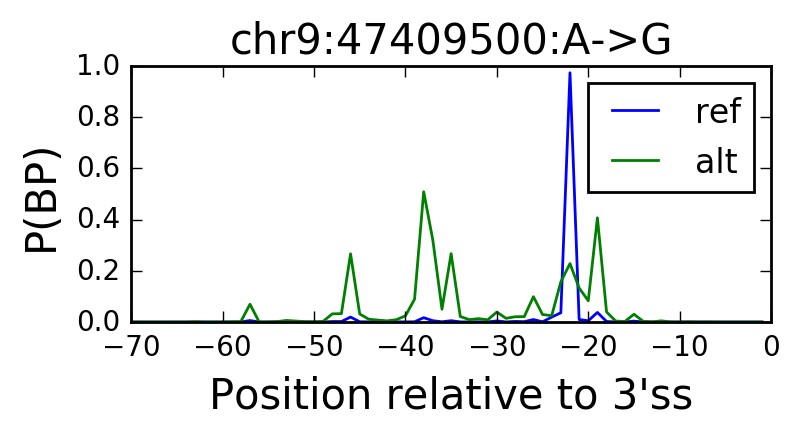

In [13]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

print pathogenic[pathogenic['POS'] == 47409500][['CHROM', 'REF', 'ALT', "3'Dist"]]
seq = X_all[47409521 == a_coords]
ref = model.predict(seq[:, :, :4])
alt = model.predict(np.hstack([seq[:, :-22, :4],
                               np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                               seq[:, -22+1:, :4]]))

print seq.shape
print seq[:, :-24, :4].shape

print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :, :4].reshape(L, 4)))
print ''.join(map(lambda x: bases[np.argmax(x)],
                  np.hstack([seq[:, :-22, :4],
                             np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                             seq[:, -22+1:, :4]]
                           ).reshape(L, 4)))


fig = plt.figure()
adjustFigAspect(fig,aspect=2.5)

ax = fig.add_subplot(111)
plt.plot(range(-L, 0), ref[0], label = 'ref')
plt.plot(range(-L, 0), alt[0], label = 'alt')
plt.legend(loc = 'best')
plt.ylabel('P(BP)')
plt.xlabel("Position relative to 3'ss")
plt.title('chr9:47409500:A->G')
plt.show()

# ExAC (Likely Benign Variant) Enrichments

A+T are apparently less mutable than other positions.

Here we make sure the de-enrichments in benign variants hold for
TNA motifs with matched distance to the 3'ss.

In [14]:
import gzip
ExAC_chrom = []
ExAC_pos = []
ExAC_alfq = []
with open('../anno/ExAC.bpregion.vcf') as fp:
    for i, line in enumerate(fp):
        if line[0] == '#': continue
        chrom, pos, _, ref, alt, _, _, info = line.strip().split('\t')
        
        # Just skip deletions.
        # They don't provide precise positional info.
        if len(ref) > 1: continue
        if info[-1] == '.': continue
        
        # Take the sum of all the alt alleles
        alfq = sum(map(lambda x: float(x.split(':')[2]),
                       info.split(','))[1:])
        
        ExAC_chrom += ['chr'+chrom]
        ExAC_pos += [int(pos)]
        ExAC_alfq += [alfq]
ExAC_chrom = np.array(ExAC_chrom)
ExAC_pos = np.array(ExAC_pos)
ExAC_alfq = np.array(ExAC_alfq)

In [15]:
def count(D):
    return float(sum(len(d) for d in D.values()))

def var_enrichment(chroms, positions, bps):
    hits = np.zeros((2*K+1,))
    for chrom, pos in zip(chroms, positions):
        if chrom == 'chrY': continue
        for shift in range(-K, K+1):
            if pos-shift in bps[chrom] and bps[chrom][pos-shift] == '+':
                hits[shift+K] += 1
            if pos+shift in bps[chrom] and bps[chrom][pos+shift] == '-':
                hits[shift+K] += 1
    return hits

def matched(X, y, chroms, coords, strands):
    branch, not_branch = {}, {}
    bps, n_bps = {}, {}
    for chrom, pos, strand, target, seq in zip(chroms, coords, strands, y, X):
        bp = np.argmax(target)
        for i in range(K, L-K):
            if not seq[i, 0]*seq[i-2, 3]: continue
            idx = pos + (i-L+1 if strand == '+' else L-i)
            if i == bp:
                if chrom not in bps: bps[chrom] = set()
                if idx in bps[chrom]: continue
                bps[chrom].add(idx)
                if i not in branch: branch[i] = set()
                branch[i].add((chrom, idx, strand))
            else:
                if chrom not in n_bps: n_bps[chrom] = set()
                if idx in n_bps[chrom]: continue
                n_bps[chrom].add(idx)
                if i not in not_branch: not_branch[i] = set()
                if (chrom, idx) in not_branch[i]: continue
                not_branch[i].add((chrom, idx, strand))
                
    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = list(branch[dist])[:num]
        not_branch[dist] = list(not_branch[dist])[:num]
    
    n_bps = {}
    for key, value in not_branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx, strand) in value:
            if chrom not in n_bps: n_bps[chrom] = {}
            assert idx not in n_bps[chrom]
            n_bps[chrom][idx] = strand
    
    bps = {}
    for key, value in branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx, strand) in value:
            if chrom not in bps: bps[chrom] = {}
            assert idx not in bps[chrom]
            bps[chrom][idx] = strand

    return bps, n_bps

In [16]:
K = 15
bps, n_bps = matched(X_all,  y_all, a_chroms, a_coords, a_strands)
print count(bps), count(n_bps)

134795.0 134795.0


In [17]:
rare_bp_hits = var_enrichment(ExAC_chrom[ExAC_alfq < 0.0001], ExAC_pos[ExAC_alfq < 0.0001], bps)
rare_nbp_hits = var_enrichment(ExAC_chrom[ExAC_alfq < 0.0001], ExAC_pos[ExAC_alfq < 0.0001], n_bps)

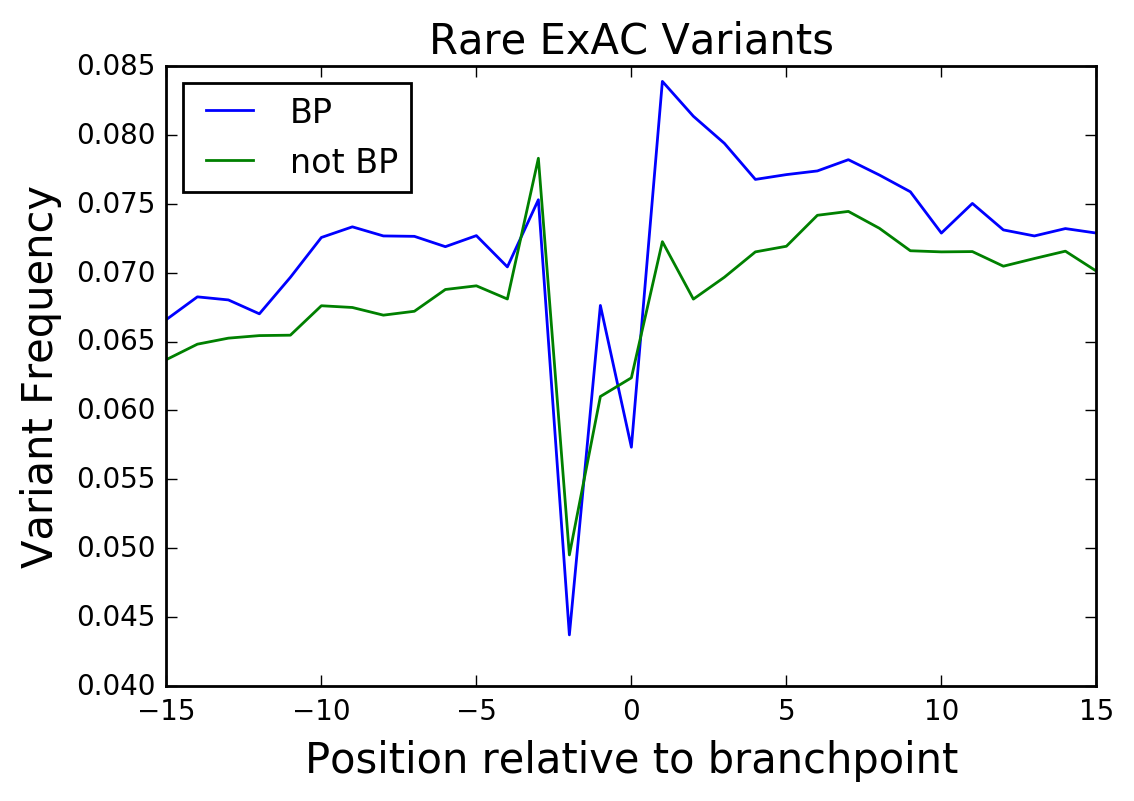

-15 1.04566103669
(1.0489189101788716, 0.0022760052020586591)
-14 1.05299908425
(1.0568808844338617, 0.00035594243435740295)
-13 1.04252416146
(1.0456278504718524, 0.0039682465466020136)
-12 1.02414965986
(1.0258842369027252, 0.10059904036510231)
-11 1.06414324569
(1.0689461249811716, 1.4524881489085618e-05)
-10 1.07330992098
(1.0790450009914525, 4.835434369370172e-07)
-9 1.08675096207
(1.0936154216348495, 2.9686912060357549e-09)
-8 1.08592017738
(1.0926528824833703, 4.8768173762781923e-09)
-7 1.08092294105
(1.0872612703463482, 3.2185818114379395e-08)
-6 1.04519469313
(1.0486952452766771, 0.0016413960965930043)
-5 1.05275599011
(1.0568913148919334, 0.00023512958700412482)
-4 1.03421224668
(1.0368039056591152, 0.017574806199626279)
-3 0.961534817622
(0.95840288289519771, 0.0033952734233111902)
-2 0.882828888223
(0.87747313862371845, 9.5017714260879233e-13)
-1 1.10834143969
(1.1161989526005767, 2.7730110493240451e-12)
0 0.91923397169
(0.91432191846811794, 3.6790890935871443e-08)
1 1.1610

In [18]:
from scipy.stats import fisher_exact


def compare_frequency(hits1, hits2, n1, n2, name1, name2, title):
    plt.plot(range(-K, K+1),  hits1 / n1, label = name1)
    plt.plot(range(-K, K+1),  hits2 / n2, label = name2)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.ylabel('Variant Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.show()

    for i in range(2*K+1):
        print i-K, (hits1[i]/n1) / (hits2[i]/n2)
        print fisher_exact([[hits1[i], n1-hits1[i]],
                                 [hits2[i], n2-hits2[i]]])

compare_frequency(rare_bp_hits, rare_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Rare ExAC Variants')

In [19]:
common_bp_hits = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.0001], ExAC_pos[ExAC_alfq >= 0.0001], bps)
common_nbp_hits = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.0001], ExAC_pos[ExAC_alfq >= 0.0001], n_bps)

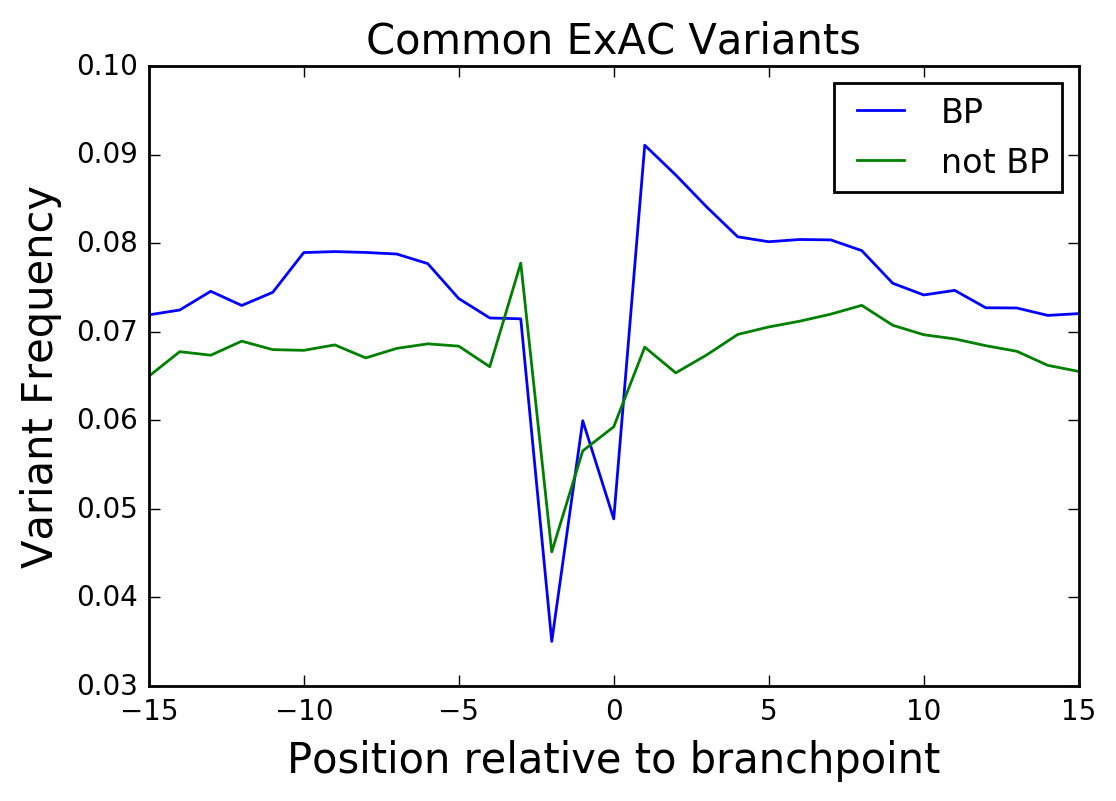

-15 1.10677172548
(1.1150435619900407, 1.0341966325243174e-12)
-14 1.0694261936
(1.0748490651526708, 1.7931300742938707e-06)
-13 1.10718219872
(1.1158181914701868, 3.0384547882451134e-13)
-12 1.05843736548
(1.0630366891748881, 4.78001208781305e-05)
-11 1.09516533886
(1.1028199090414679, 6.8556155756052131e-11)
-10 1.16258741259
(1.1765210444985725, 4.4977015362177018e-28)
-9 1.15376285869
(1.1669604038753598, 1.3369973526727418e-25)
-8 1.1776031869
(1.1928267667954644, 1.4708146158755909e-32)
-7 1.15639294271
(1.1697656306170578, 3.0167649759574556e-26)
-6 1.13198573127
(1.1431031799976592, 1.7797903512239653e-19)
-5 1.07855902778
(1.084813296618522, 5.9440531777180498e-08)
-4 1.08334269347
(1.0897657080850391, 1.7106103511415323e-08)
-3 0.919083969466
(0.91285702375400191, 5.3188113247828181e-10)
-2 0.776170912079
(0.76804353045753859, 8.0308971904140753e-41)
-1 1.06008133281
(1.0639129319249332, 0.00017119620427895812)
0 0.824508699462
(0.81549240409294221, 7.3233944244596665e-33)
1 

In [20]:
compare_frequency(common_bp_hits, common_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Common ExAC Variants')

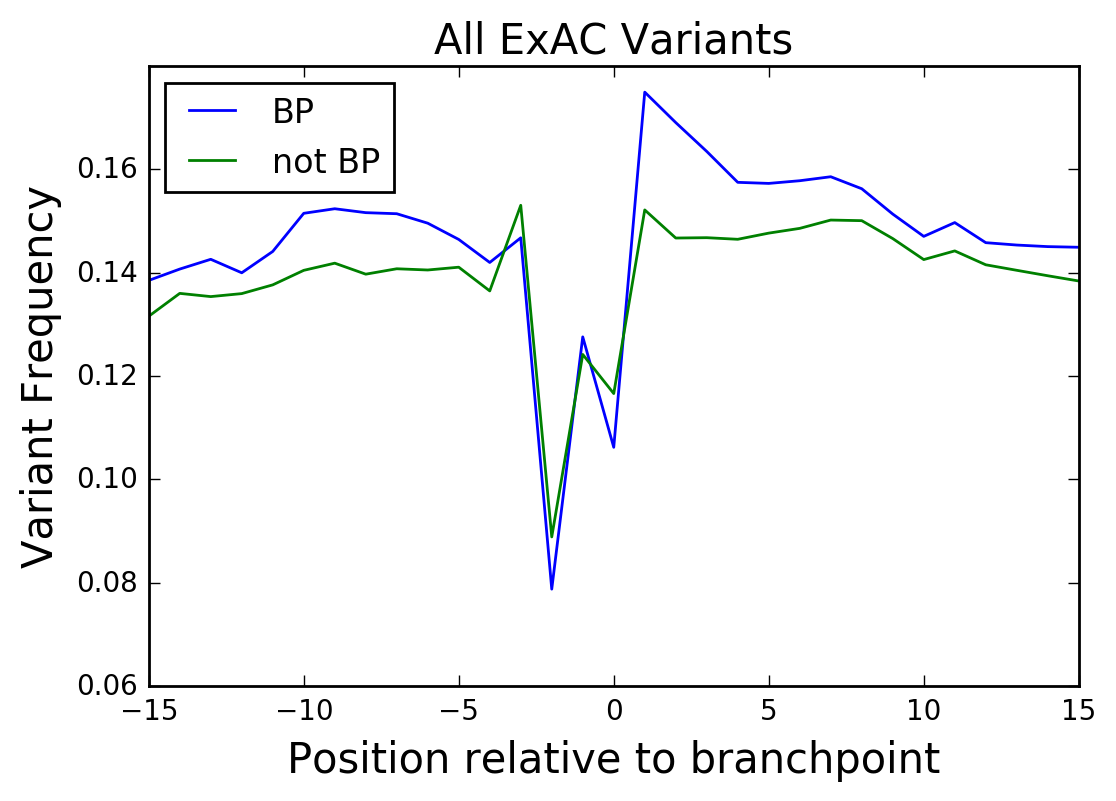

-15 1.05272358182
(1.0611996900905758, 1.4112122522039255e-07)
-14 1.03458622006
(1.0402490678889493, 0.00041378748544020473)
-13 1.05332383405
(1.0621915311393642, 6.2336989767869934e-08)
-12 1.02963165075
(1.0344544270350498, 0.0024700069040668026)
-11 1.0470004851
(1.0549140191437669, 1.4203111705383511e-06)
-10 1.0785970843
(1.0926294555492826, 4.9741962255324473e-16)
-9 1.07427166693
(1.087622963726937, 1.1976962706100865e-14)
-8 1.08522727273
(1.1004582996141303, 1.9836099113993445e-18)
-7 1.07568650187
(1.0891906528745845, 5.0396649998251082e-15)
-6 1.06446333351
(1.0758013402806224, 2.5083819952009237e-11)
-5 1.03807720627
(1.0446093416223141, 7.2123621098288605e-05)
-4 1.04033704811
(1.0470112953717747, 3.7444618939147699e-05)
-3 0.958892820786
(0.95182288919510238, 4.8774237221870329e-06)
-2 0.886282040578
(0.8765613436920684, 3.0071169549144315e-21)
-1 1.02736288684
(1.0313640450359125, 0.0079665871403257656)
0 0.910797225934
(0.90019847335436098, 9.6939878131582506e-18)
1 1

In [21]:
compare_frequency(common_bp_hits+rare_bp_hits, common_nbp_hits+rare_bp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'All ExAC Variants')

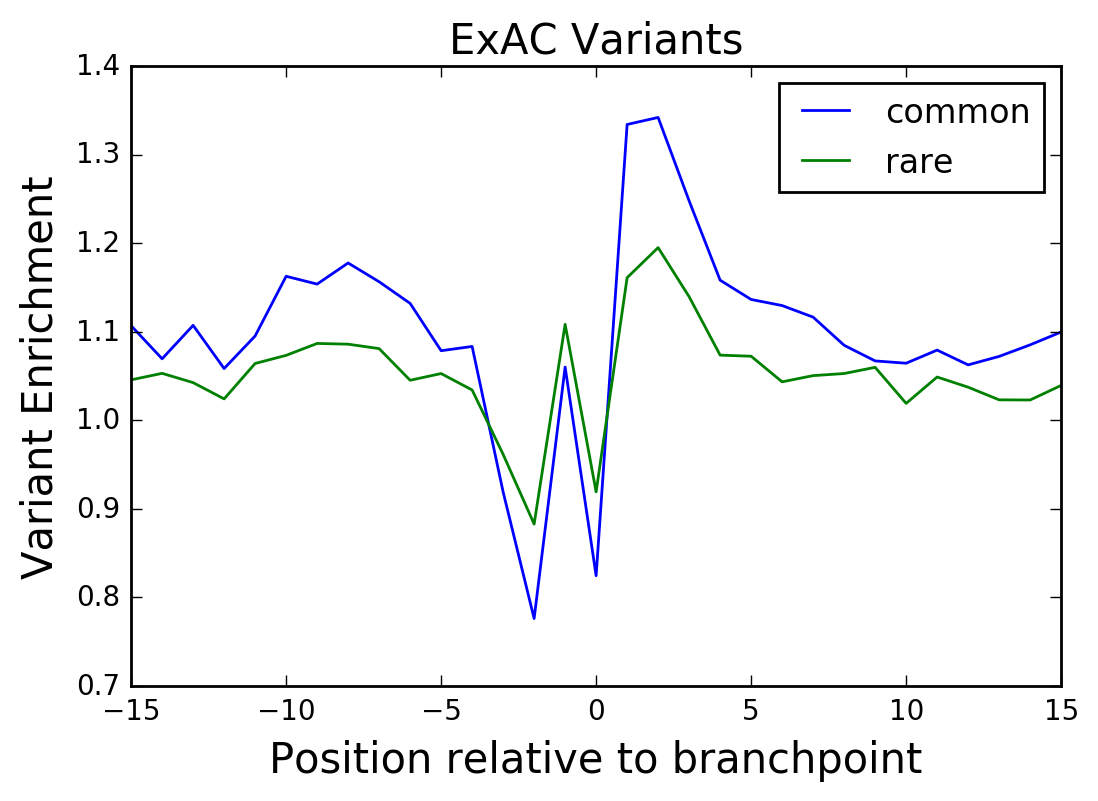

Fisher Exact test comparing enrichment in common to rare
-15 (1.0584421592088669, 0.0071430469076979967)
-14 (1.0156003073521531, 0.45902891477051122)
-13 (1.0620206606785496, 0.0038500546117150964)
-12 (1.0334791944531694, 0.1160168464628682)
-11 (1.0291521778621411, 0.16543611540969466)
-10 (1.0831796015845097, 9.152387851231648e-05)
-9 (1.0616626062103838, 0.0033105861702387735)
-8 (1.0844288663422899, 7.3774426925730677e-05)
-7 (1.0698199647741256, 0.00095857857526170716)
-6 (1.0830381542441121, 9.2617866647026872e-05)
-5 (1.0245099889291465, 0.23942174546446304)
-4 (1.0475051876006511, 0.025758872060701706)
-3 (0.9558509506069488, 0.022718483281237184)
-2 (0.87918612817624942, 1.0886770523782576e-06)
-1 (0.9564573648950051, 0.043640686163907191)
0 (0.8969519457007008, 2.1167395347897918e-06)
1 (1.1489947965653753, 1.1282297098174676e-12)
2 (1.1230008823855744, 6.4073234734638429e-09)
3 (1.0949720939957694, 5.6451162582281998e-06)
4 (1.078832198364285, 0.0001485461785036669)
5 (1.0

In [22]:
from scipy.stats import fisher_exact

def compare_enrichments(hits1, hits2, n_hits1, n_hits2, name1, name2, title):
    plt.plot(range(-K, K+1), hits1 / n_hits1, label = name1)
    plt.plot(range(-K, K+1), hits2 / n_hits2, label = name2)
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('Variant Enrichment')
    plt.xlabel('Position relative to branchpoint')
    plt.show()
    
    print "Fisher Exact test comparing enrichment in {} to {}".format(name1, name2)
    for i in range(-K, K+1):
        i += K
        print i-K,
        print fisher_exact([[hits1[i], n_hits1[i]],
                           [hits2[i], n_hits2[i]]])

compare_enrichments(common_bp_hits, rare_bp_hits, common_nbp_hits, rare_nbp_hits,
                    'common', 'rare', 'ExAC Variants')

In [23]:
v_common_bp_hits = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.001], ExAC_pos[ExAC_alfq >= 0.001], bps)
v_common_nbp_hits = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.001], ExAC_pos[ExAC_alfq >= 0.001], n_bps)

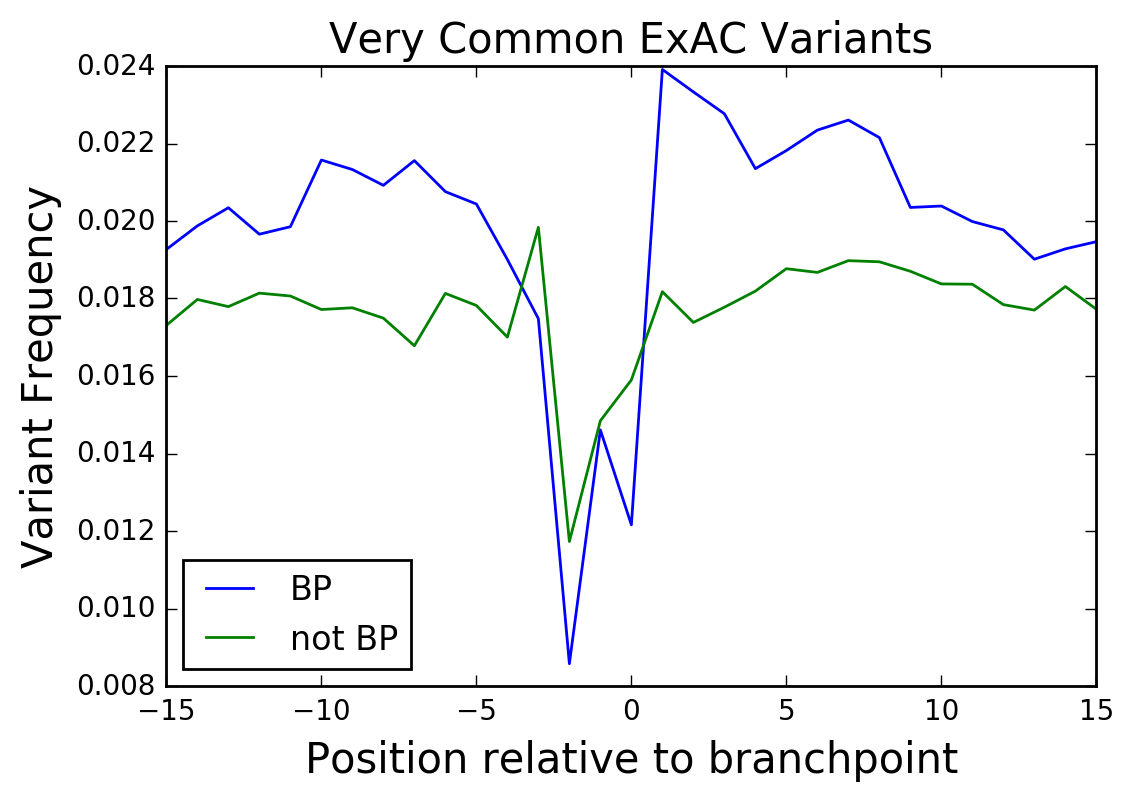

-15 1.11315902272
(1.115382006287611, 0.00015604966006887812)
-14 1.10565414775
(1.1077965639745269, 0.00031219760532529331)
-13 1.1434528774
(1.1464315888987051, 1.350378048302214e-06)
-12 1.08384458078
(1.0855259772662504, 0.0039054290210202196)
-11 1.09897330595
(1.1009779575699232, 0.00069919652895858594)
-10 1.21775544389
(1.2225567725297146, 5.6627333788647407e-13)
-9 1.20091896408
(1.2052976937745616, 2.3458247137964483e-11)
-8 1.19592875318
(1.2001152967227677, 9.6067019284752353e-11)
-7 1.28470380195
(1.2909768743655703, 1.5284370273055639e-19)
-6 1.14484451718
(1.1479148518068165, 8.4172904620227797e-07)
-5 1.14696086595
(1.150027188163151, 7.3815320155173539e-07)
-4 1.11780104712
(1.1200834296022693, 9.7321532177769787e-05)
-3 0.881077038145
(0.87896147929815904, 6.3810460925355132e-06)
-2 0.731182795699
(0.72885748132084616, 3.2946861983087277e-16)
-1 0.984007996002
(0.98377093205463884, 0.62013641326253255)
0 0.764815678955
(0.76192082553323681, 1.5974511434062857e-16)
1 1

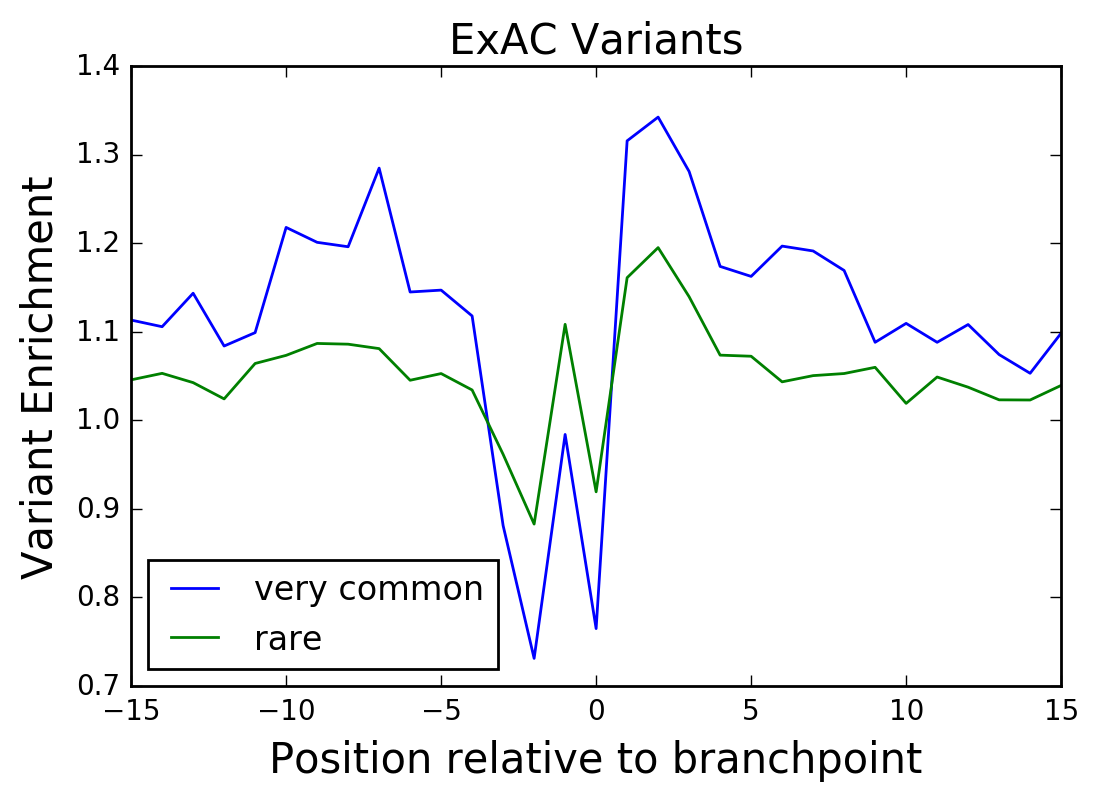

Fisher Exact test comparing enrichment in very common to rare
-15 (1.0645505413868781, 0.05300858750268958)
-14 (1.0500048521306999, 0.12751519362794675)
-13 (1.0968118722558544, 0.0035910327841902345)
-12 (1.0582873023861383, 0.075217701827693523)
-11 (1.032730612539444, 0.31078473523029315)
-10 (1.1345795096820162, 5.1742507594533931e-05)
-9 (1.1050544292067008, 0.0013906885118754153)
-8 (1.1013044771505429, 0.0021826124563718761)
-7 (1.18852487366147, 4.7838188835080851e-08)
-6 (1.0953409204150262, 0.0036828868923826723)
-5 (1.0894840558634968, 0.0065961579495894445)
-4 (1.0808236420639701, 0.016332862947677738)
-3 (0.91632359223781068, 0.0056423712226520758)
-2 (0.82822708392644662, 9.7012197720657405e-06)
-1 (0.8878202697883093, 0.00076890670533107737)
0 (0.83201415799333189, 4.3926795960896978e-07)
1 (1.1330816200186629, 3.3965157339165979e-05)
2 (1.1233131716867617, 0.00015633614444613244)
3 (1.1240808552521655, 0.00013870583337829954)
4 (1.0933164536448083, 0.003906653437435850

In [24]:
compare_frequency(v_common_bp_hits, v_common_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Very Common ExAC Variants')

compare_enrichments(v_common_bp_hits, rare_bp_hits, v_common_nbp_hits, rare_nbp_hits,
                    'very common', 'rare', 'ExAC Variants')

# No -2 T variant enrichments

The plot thickens.

In [25]:
def matched_noT(X, y, chroms, coords, strands):
    branch, not_branch = {}, {}
    bps, n_bps = {}, {}
    for chrom, pos, strand, target, seq in zip(chroms, coords, strands, y, X):
        bp = np.argmax(target)
        for i in range(K, L-K):
            if not seq[i, 0]*(1-seq[i-2, 3]): continue
            idx = pos + (i-L+1 if strand == '+' else L-i)
            if i == bp:
                if chrom not in bps: bps[chrom] = set()
                if idx in bps[chrom]: continue
                bps[chrom].add(idx)
                if i not in branch: branch[i] = set()
                branch[i].add((chrom, idx, strand))
            else:
                if chrom not in n_bps: n_bps[chrom] = set()
                if idx in n_bps[chrom]: continue
                n_bps[chrom].add(idx)
                if i not in not_branch: not_branch[i] = set()
                not_branch[i].add((chrom, idx, strand))
                
    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = list(branch[dist])[:num]
        not_branch[dist] = list(not_branch[dist])[:num]
    
    n_bps = {}
    for key, value in not_branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx, strand) in value:
            if chrom not in n_bps: n_bps[chrom] = {}
            assert idx not in n_bps[chrom]
            n_bps[chrom][idx] = strand
    
    bps = {}
    for key, value in branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx, strand) in value:
            if chrom not in bps: bps[chrom] = {}
            assert idx not in bps[chrom]
            bps[chrom][idx] = strand

    return bps, n_bps

In [26]:
K = 15
bps_noT, n_bps_noT = matched_noT(X_all,  y_all, a_chroms, a_coords, a_strands)
print count(bps_noT), count(n_bps_noT)

37486.0 37486.0


In [27]:
rare_bp_hits_noT = var_enrichment(ExAC_chrom[ExAC_alfq < 0.0001], ExAC_pos[ExAC_alfq < 0.0001], bps_noT)
rare_nbp_hits_noT = var_enrichment(ExAC_chrom[ExAC_alfq < 0.0001], ExAC_pos[ExAC_alfq < 0.0001], n_bps_noT)

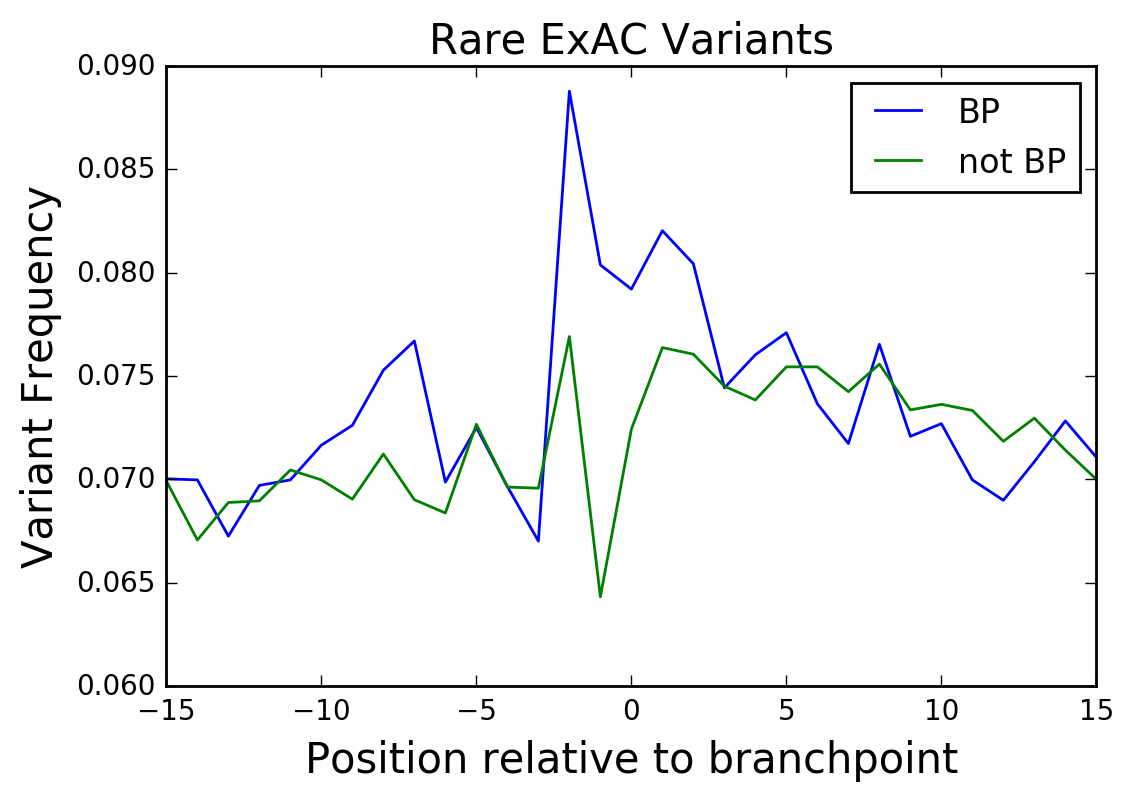

-15 1.00152613506
(1.0016410515753953, 0.96574216727950468)
-14 1.04335719968
(1.0466192808212511, 0.11844926712247301)
-13 0.976374903176
(0.97467151781636674, 0.38427303646873789)
-12 1.01083172147
(1.0116433318333709, 0.69787616373690731)
-11 0.993184399849
(0.99267161210229915, 0.80801088165107848)
-10 1.02401829966
(1.0258721258890189, 0.3773771159534427)
-9 1.05177743431
(1.0558315758436172, 0.05828800765723452)
-8 1.05692883895
(1.0615634219054015, 0.034288742059557481)
-7 1.11132586007
(1.1205732625630067, 5.4871923805852965e-05)
-6 1.02184939524
(1.0234905908155243, 0.42842501399071364)
-5 0.997797356828
(0.9976251644633477, 0.94389131122704029)
-4 1.00038314176
(1.0004118265837212, 1.0)
-3 0.963190184049
(0.96054632696471098, 0.16898273662699564)
-2 1.15435310441
(1.1693916643752806, 3.9807634447610269e-09)
-1 1.24968892576
(1.2715121710012163, 2.2390219662914514e-17)
0 1.09355432781
(1.1016014581866431, 0.00048085334245942952)
1 1.07404820119
(1.0806652195436657, 0.004320525

In [28]:
compare_frequency(rare_bp_hits_noT, rare_nbp_hits_noT, count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'Rare ExAC Variants')

In [29]:
common_bp_hits_noT = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.0001], ExAC_pos[ExAC_alfq >= 0.0001], bps_noT)
common_nbp_hits_noT = var_enrichment(ExAC_chrom[ExAC_alfq >= 0.0001], ExAC_pos[ExAC_alfq >= 0.0001], n_bps_noT)

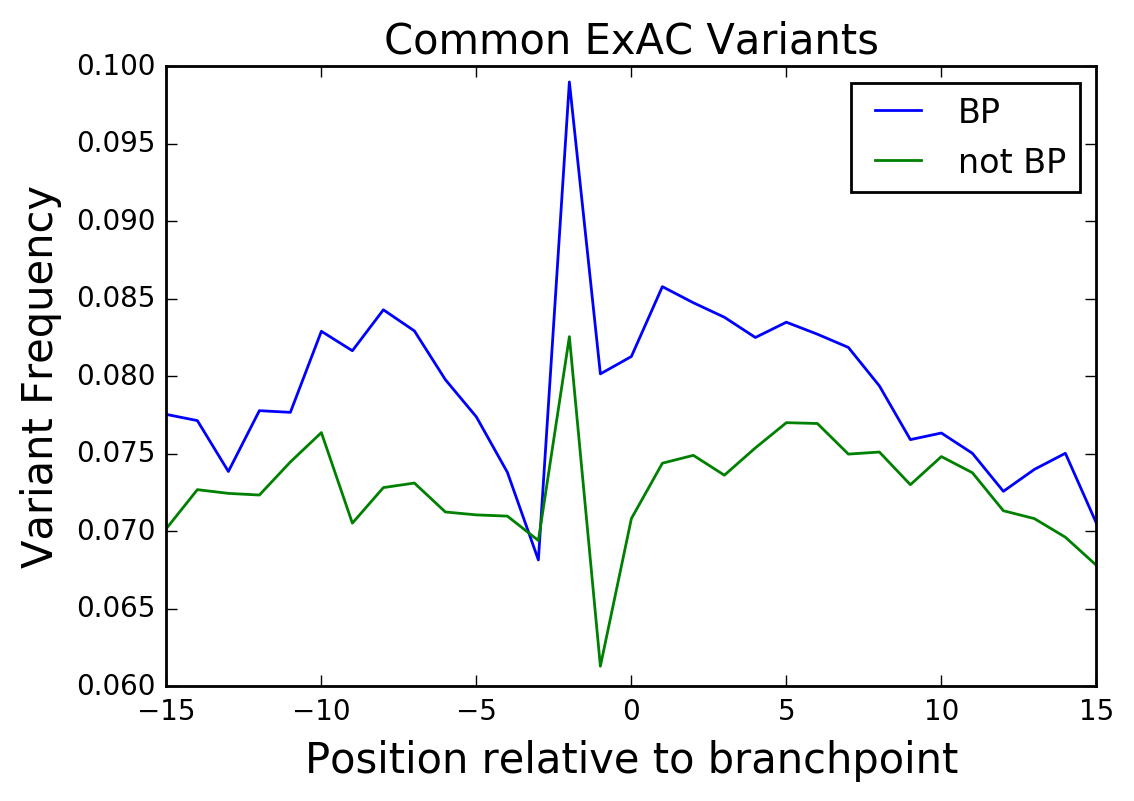

-15 1.10494296578
(1.1137620594334623, 0.00012242487232256666)
-14 1.06130690162
(1.066430134815727, 0.021258730447037508)
-13 1.01952117864
(1.0210775650208568, 0.46573922629497466)
-12 1.07524898561
(1.0815939219210486, 0.0048880885585407124)
-11 1.04299534217
(1.0466152826213169, 0.10110285524226134)
-10 1.0856044724
(1.0933409712985003, 0.00099356062606457962)
-9 1.15777525539
(1.1717993151574255, 9.8572184617201562e-09)
-8 1.15756687431
(1.1720672313483464, 5.6607905468473653e-09)
-7 1.13430656934
(1.1464487770781941, 5.7488363443508707e-07)
-6 1.11985018727
(1.1302384079270114, 1.0293429600155574e-05)
-5 1.08899737139
(1.0964597080831167, 0.0010057097455635113)
-4 1.03984962406
(1.0430242801704723, 0.13886597654064009)
-3 0.981930026913
(0.98060886833993022, 0.50674807679975808)
-2 1.19909502262
(1.2209638802137479, 5.1252828310369843e-15)
-1 1.30779277318
(1.3346070383248039, 7.298593705736836e-24)
0 1.14770158252
(1.1607648525618639, 7.0586755919307496e-08)
1 1.15315638451
(1.1

In [30]:
compare_frequency(common_bp_hits_noT, common_nbp_hits_noT, count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'Common ExAC Variants')

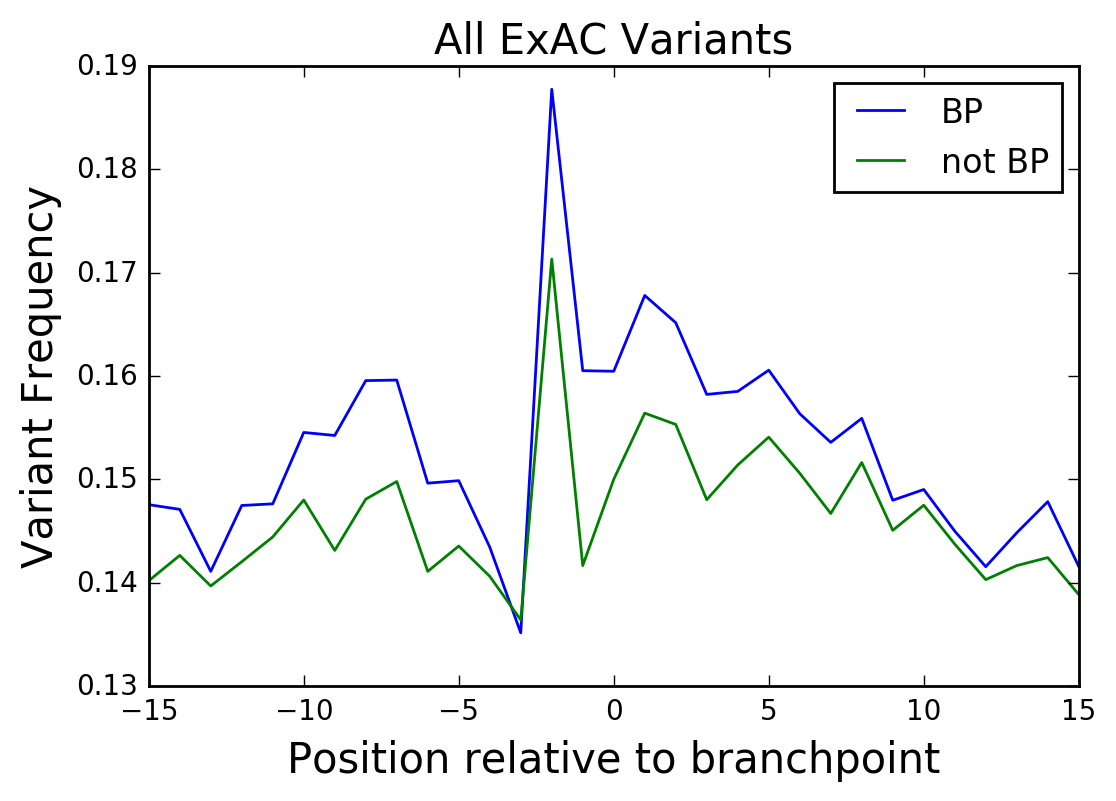

-15 1.05252140818
(1.0616121892391195, 0.0042115183828683768)
-14 1.0312324668
(1.0366189243903359, 0.084977518664146684)
-13 1.01012223071
(1.011785009175157, 0.58459382983328267)
-12 1.03831705485
(1.0449450252818206, 0.035101671211656436)
-11 1.02216475803
(1.0260036341915904, 0.21842792146788303)
-10 1.04416005768
(1.0522318468473828, 0.012879320093895946)
-9 1.07772600186
(1.0919012397764127, 1.9477280775583261e-05)
-8 1.07746352009
(1.0921694179959196, 1.4039980001411533e-05)
-7 1.06553873553
(1.0779857486611193, 0.00020990918883452119)
-6 1.06050293061
(1.0711488802858724, 0.00094773761232275927)
-5 1.04404385802
(1.0518083363153812, 0.014845805256455617)
-4 1.02011003605
(1.0234776795051626, 0.27196550598795266)
-3 0.990807744964
(0.98937134878820698, 0.6238202850165474)
-2 1.09592027406
(1.1180920715099649, 4.8260652488898589e-09)
-1 1.13314500942
(1.1586028733984404, 5.9484561103513607e-13)
0 1.06971367597
(1.0830379351640986, 8.0242218157725861e-05)
1 1.07282960941
(1.087514

In [31]:
compare_frequency(common_bp_hits_noT+rare_bp_hits_noT, common_nbp_hits_noT+rare_bp_hits_noT,
                  count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'All ExAC Variants')

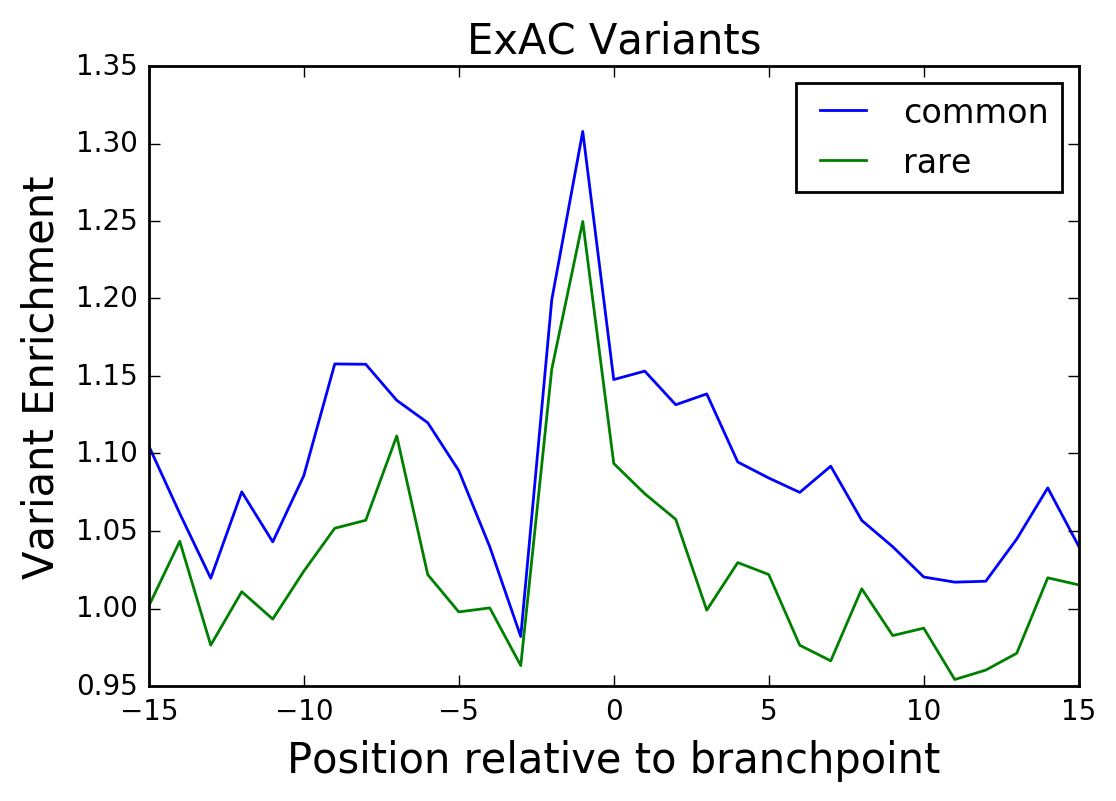

Fisher Exact test comparing enrichment in common to rare
-15 (1.1032592431649466, 0.010956922336769769)
-14 (1.0172037936182969, 0.67091684749196112)
-13 (1.0441902749866134, 0.26761966409765747)
-12 (1.0637269911261444, 0.11024407241031721)
-11 (1.050152763505265, 0.20709749083579554)
-10 (1.0601416720391419, 0.12634930029471175)
-9 (1.100779706448737, 0.012371341142678509)
-8 (1.09521741829041, 0.016197049070735658)
-7 (1.0206786417010474, 0.597666024577169)
-6 (1.0959053188096781, 0.017966031634906704)
-5 (1.0914013390929085, 0.022122405932511524)
-4 (1.0394513668314793, 0.3228083182287102)
-3 (1.0194560152023842, 0.6358046881211401)
-2 (1.0387592999477897, 0.28281938899547243)
-1 (1.0464946485704596, 0.24308087174930504)
0 (1.0495149196812172, 0.20171891380502024)
1 (1.073654220760285, 0.054284003563024277)
2 (1.0699118113269301, 0.068618802646249727)
3 (1.13968010850121, 0.00047701834917403556)
4 (1.0630220152150287, 0.10493171889148403)
5 (1.0609399391406311, 0.11207601028399089)

In [32]:
compare_enrichments(common_bp_hits_noT, rare_bp_hits_noT, common_nbp_hits_noT, rare_nbp_hits_noT,
                    'common', 'rare', 'ExAC Variants')

# pLI Variant Enrichment

In [33]:
pLI = {}
with open('../anno/fordist_cleaned_exac_r03_march16_z_pli_rec_null_data.txt') as fp:
    print fp.readline().strip()
    for line in fp:
        gene = line.split()[1]
        pli = float(line.split()[19])
        pLI[gene] = pli
len(pLI)

transcript	gene	chr	n_exons	cds_start	cds_end	bp	mu_syn	mu_mis	mu_lof	n_syn	n_mis	n_lof	exp_syn	exp_mis	exp_lof	syn_z	mis_z	lof_z	pLI	pRec	pNull


18225

In [34]:
pLI_idx     = np.array([gene in pLI and pLI[gene] >= 0.9 for gene in a_genes])
not_pLI_idx = np.array([gene in pLI and pLI[gene] < 0.9 for gene in a_genes])
print sum(pLI_idx), sum(not_pLI_idx)

56448 140792


In [35]:
pli_bps, pli_n_bps = matched(X_all[pLI_idx],  y_all[pLI_idx],
                             a_chroms[pLI_idx], a_coords[pLI_idx], a_strands[pLI_idx])
not_pli_bps, not_pli_n_bps = matched(X_all[not_pLI_idx],  y_all[not_pLI_idx],
                                     a_chroms[not_pLI_idx], a_coords[not_pLI_idx], a_strands[not_pLI_idx])

In [36]:
pli_bp_hits = var_enrichment(ExAC_chrom, ExAC_pos, pli_bps)
pli_nbp_hits = var_enrichment(ExAC_chrom, ExAC_pos, pli_n_bps)

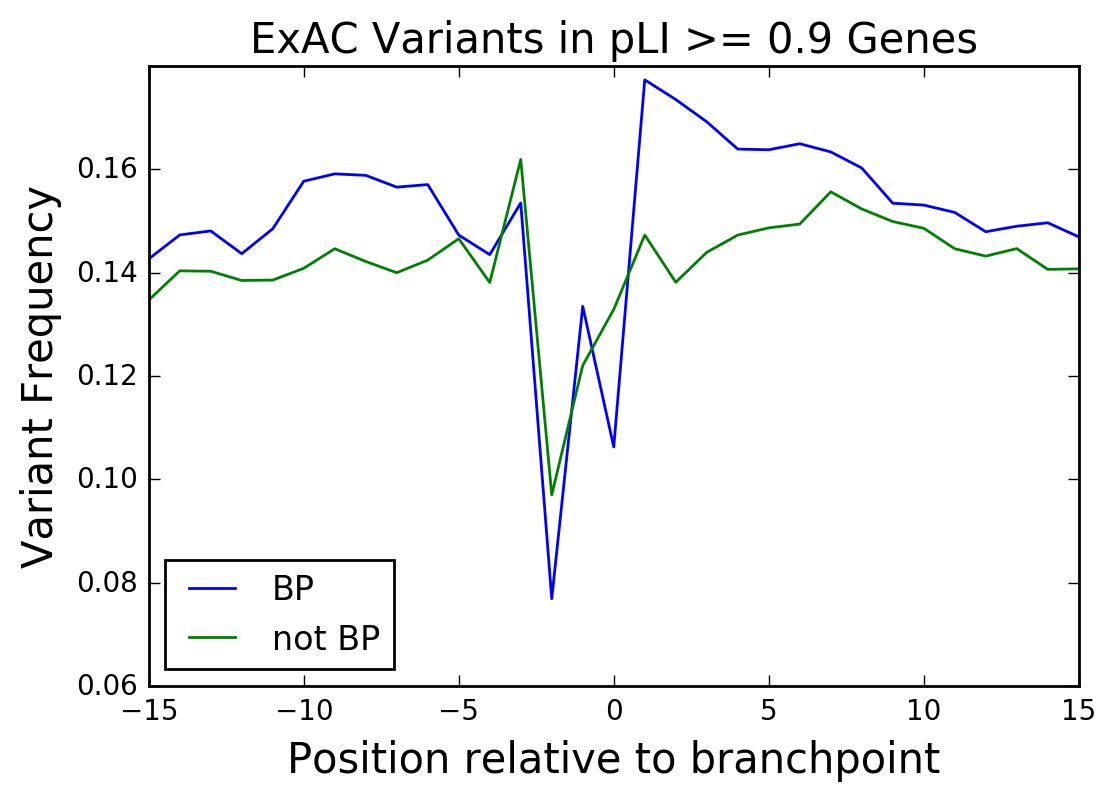

-15 1.0590839107
(1.0689154477143898, 0.0014335977025082313)
-14 1.04950129294
(1.0580525013386322, 0.0061542504919270616)
-13 1.05562742561
(1.0652964614342797, 0.0021053480800964572)
-12 1.03743916136
(1.0437205803586851, 0.039569700812474615)
-11 1.07165575304
(1.0841517694018639, 8.7483256527581935e-05)
-10 1.11963924167
(1.1420382293012681, 5.4406813726459771e-11)
-9 1.10019716795
(1.1191578972916314, 2.1633196231883067e-08)
-8 1.11725018235
(1.1393906534939084, 1.0086997403192924e-10)
-7 1.11833333333
(1.1402978331028124, 1.0127676887186838e-10)
-6 1.10265744448
(1.1217833762935248, 1.3339886171802233e-08)
-5 1.00477538026
(1.0056001434413764, 0.79146915306669618)
-4 1.03904636756
(1.0455877775452194, 0.03213149536153273)
-3 0.947966698687
(0.9385314499481977, 0.0013710447702710445)
-2 0.79283614007
(0.77558024227816502, 4.135279600295605e-23)
-1 1.09367034834
(1.1080999257140569, 2.0751518918474337e-06)
0 0.799648849005
(0.77582754754232497, 4.4317321946961347e-30)
1 1.204013377

In [37]:
compare_frequency(pli_bp_hits, pli_nbp_hits, count(pli_bps), count(pli_n_bps),
                  'BP', 'not BP', 'ExAC Variants in pLI >= 0.9 Genes')

In [38]:
not_pli_bp_hits = var_enrichment(ExAC_chrom, ExAC_pos, not_pli_bps)
not_pli_nbp_hits = var_enrichment(ExAC_chrom, ExAC_pos, not_pli_n_bps)

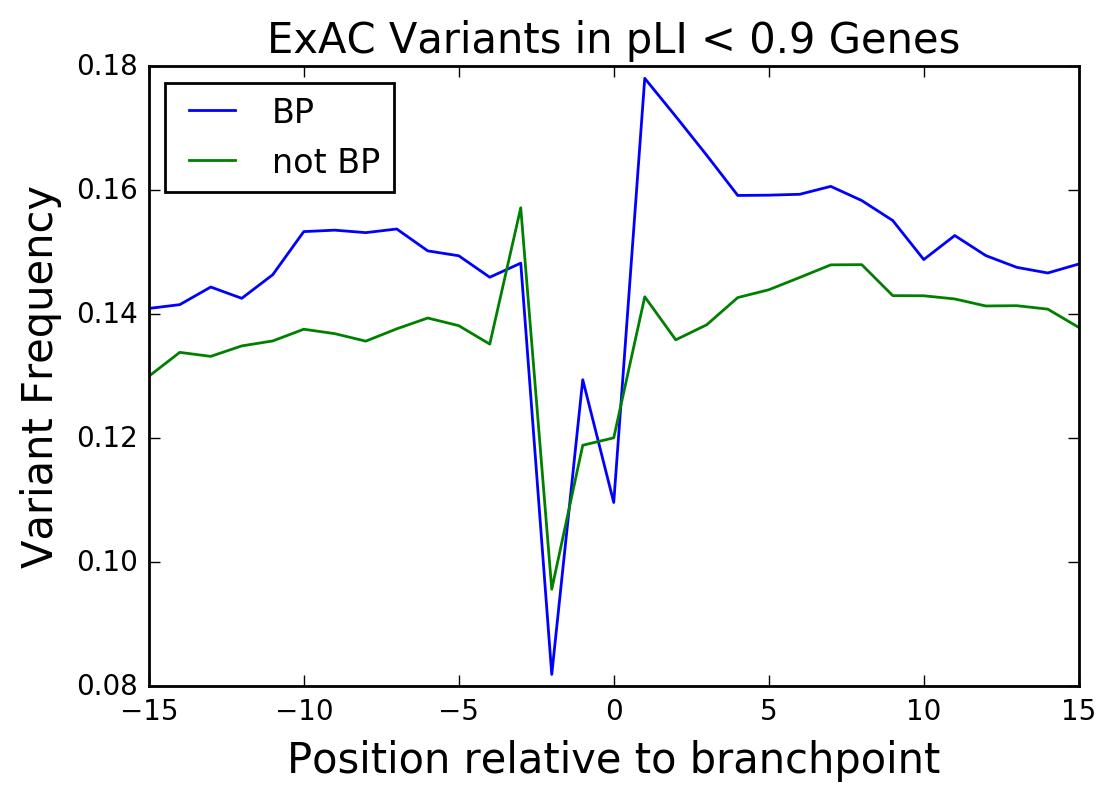

-15 1.08426630203
(1.0980862892769108, 1.1676500175344781e-11)
-14 1.05751514649
(1.066995477087028, 2.2114982726542508e-06)
-13 1.08397965141
(1.0981472050927756, 6.9729187489855957e-12)
-12 1.05690521288
(1.0663639882110834, 2.5436734541237379e-06)
-11 1.07875562833
(1.092256212632035, 7.6359221016166745e-11)
-10 1.11449333872
(1.1352214354909267, 2.6943826474115746e-21)
-9 1.12198685172
(1.1441112824919586, 9.2446267299434263e-24)
-8 1.12905339011
(1.1523874859000878, 4.4488657759683382e-26)
-7 1.11702041805
(1.138274940198599, 3.6226738726461648e-22)
-6 1.07770162576
(1.0914330897166491, 6.8688825194331387e-11)
-5 1.08161132106
(1.0959446869123757, 9.673894476299461e-12)
-4 1.07979291643
(1.0934263462670568, 4.7821878909447971e-11)
-3 0.943176196198
(0.9332894470223454, 1.4302056230078621e-07)
-2 0.856313160646
(0.84350052073051995, 1.2224311126283364e-24)
-1 1.08897196262
(1.1021963743425023, 1.0637995316606233e-11)
0 0.913119911177
(0.90242569349835988, 4.0804759067532104e-12)
1 

In [39]:
compare_frequency(not_pli_bp_hits, not_pli_nbp_hits, count(not_pli_bps), count(not_pli_n_bps),
                  'BP', 'not BP', 'ExAC Variants in pLI < 0.9 Genes')

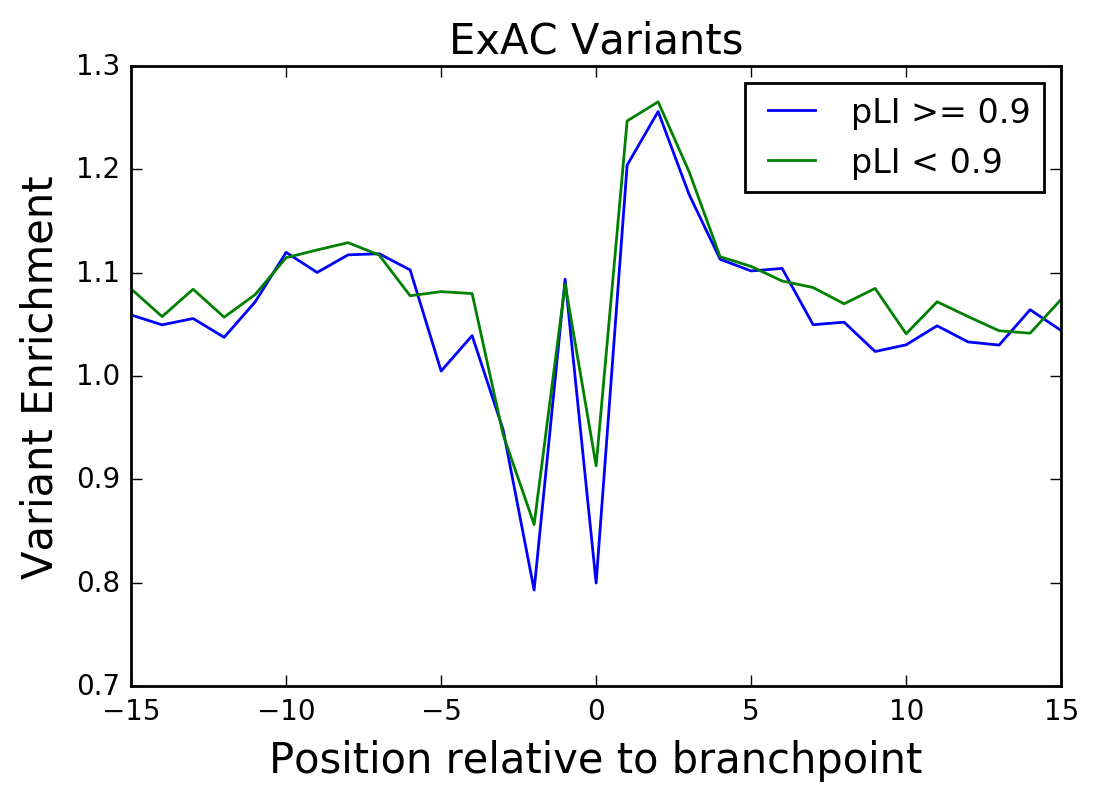

Fisher Exact test comparing enrichment in pLI >= 0.9 to pLI < 0.9
-15 (0.97677471735690113, 0.31272779664088174)
-14 (0.99242199644364237, 0.740390013603206)
-13 (0.97384431916782099, 0.24932701694718373)
-12 (0.98158202714884712, 0.42127618171046166)
-11 (0.99341845817609031, 0.77572592739870538)
-10 (1.0046172577047494, 0.84026039798352792)
-9 (0.98057937690446317, 0.37911380885994106)
-8 (0.98954592593862212, 0.63864947025089691)
-7 (1.0011753726850179, 0.9641976362397755)
-6 (1.0231565195146368, 0.30871331812078157)
-5 (0.92896159710939108, 0.0010850978368007543)
-4 (0.96226447845172303, 0.093832783514429224)
-3 (1.0050791172517515, 0.81906597406341963)
-2 (0.92587172135897, 0.0085605053922638459)
-1 (1.0043145148706425, 0.8654592881526707)
0 (0.87573257270714566, 1.3593336004681441e-07)
1 (0.96567446419752156, 0.10656275182999436)
2 (0.99260932284038028, 0.74150501784840461)
3 (0.98158234052303028, 0.39847609824386387)
4 (0.99780787752252631, 0.9213173306381619)
5 (0.9960413665130

In [40]:
compare_enrichments(pli_bp_hits, not_pli_bp_hits, pli_nbp_hits, not_pli_nbp_hits,
                    'pLI >= 0.9', 'pLI < 0.9', 'ExAC Variants')